<a href="https://colab.research.google.com/github/gabrielfernandorey/IEBS/blob/main/01-Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IEBS
### Proyecto fin de Postgrado
--- 
- Preparacion de los datos
- Alumno: Gabriel Rey

## Clonar repositorio

In [1]:
user='gabrielfernandorey'
git_repository = "https://github.com/"+user+"/IEBS.git"

!git clone {git_repository}

Cloning into 'IEBS'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 58 (delta 17), reused 24 (delta 4), pack-reused 17
Unpacking objects: 100% (58/58), 62.29 MiB | 5.09 MiB/s, done.
Updating files: 100% (15/15), done.


## Importamos librerias

In [2]:
import os
import struct

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import librosa
import librosa.display
from IPython import display as ipd
from PIL import Image

In [3]:
# Setear semilla para reproduccion
seed = 42
np.random.seed(seed)

## Importar archivos WAV

In [4]:
filenames = !ls -1 '/content/IEBS/Data'
filenames

['BENTEVEO_COMÚN.wav',
 'CABECITANEGRA_COMÚN.wav',
 'CALANDRIA_GRANDE.wav',
 'CARDENAL_AMARILLO.wav',
 'CARDENAL_COMUN.wav',
 'COTORRA.wav',
 'GOLONDRINA_DOMÉSTICA.wav',
 'GORRIÓN.wav',
 'HORNERO.wav',
 'JILGUERO_DORADO.wav',
 'RUIDO.wav',
 'ZORZAL_COLORADO.wav']

In [5]:
num_samples = len(filenames)
print('Numero total de clases:', num_samples)

Numero total de clases: 12


### Atributos de los archivos de audio

In [6]:
class WavFileHelper():
    
    def read_file_properties(self, filename):
        wave_file = open(filename, "rb")

        riff = wave_file.read(12)
        fmt = wave_file.read(36)

        ChunkSizeString = riff[4:8]
        ChunkSize = struct.unpack('I', ChunkSizeString) 
        size = round(ChunkSize[0]/1024)
        
        num_channels_string = fmt[10:12]
        num_channels = struct.unpack('<H', num_channels_string)[0]

        sample_rate_string = fmt[12:16]
        sample_rate = struct.unpack("<I", sample_rate_string)[0]
        
        byte_rate_string = fmt[16:20]
        byte_rate = struct.unpack("<I", byte_rate_string)[0] 

        bit_depth_string = fmt[22:24]
        bit_depth = struct.unpack("<H", bit_depth_string)[0]
        
        timeInSec = size*1024/byte_rate
        
        return (filename, size, num_channels, sample_rate, round(timeInSec,2), bit_depth)

In [7]:
wavfilehelper = WavFileHelper()

In [8]:
audiodata = []
for file in filenames:
    data = wavfilehelper.read_file_properties('/content/IEBS/Data/'+file)
    audiodata.append(data)

In [9]:
# Visualizamos en un Pandas dataframe los atributos de los archivos de audio
audiodf = pd.DataFrame(audiodata, columns=['filename','KB','num_channels','sample_rate','timeInSec','bit_depth'])
audiodf

filename     KB  num_channels  \
0         /content/IEBS/Data/BENTEVEO_COMÚN.wav   7299             1   
1    /content/IEBS/Data/CABECITANEGRA_COMÚN.wav   8764             1   
2       /content/IEBS/Data/CALANDRIA_GRANDE.wav  10634             1   
3      /content/IEBS/Data/CARDENAL_AMARILLO.wav   5432             1   
4         /content/IEBS/Data/CARDENAL_COMUN.wav   5451             1   
5                /content/IEBS/Data/COTORRA.wav   9900             1   
6   /content/IEBS/Data/GOLONDRINA_DOMÉSTICA.wav   2151             1   
7                /content/IEBS/Data/GORRIÓN.wav   3710             1   
8                /content/IEBS/Data/HORNERO.wav   2846             1   
9        /content/IEBS/Data/JILGUERO_DORADO.wav   3605             1   
10                 /content/IEBS/Data/RUIDO.wav  12928             1   
11       /content/IEBS/Data/ZORZAL_COLORADO.wav  13079             1   

    sample_rate  timeInSec  bit_depth  
0         44100      84.74         16  
1         44100     101.75         16  
2         44100     123.46         16  
3         44100      63.07         16  
4         44100      63.29         16  
5         44100     114.94         16  
6         44100      24.97         16  
7         44100      43.07         16  
8         44100      33.04         16  
9         44100      41.85         16  
10        44100     150.09         16  
11        44100     151.85         16

### Cargar un audio de ejemplo

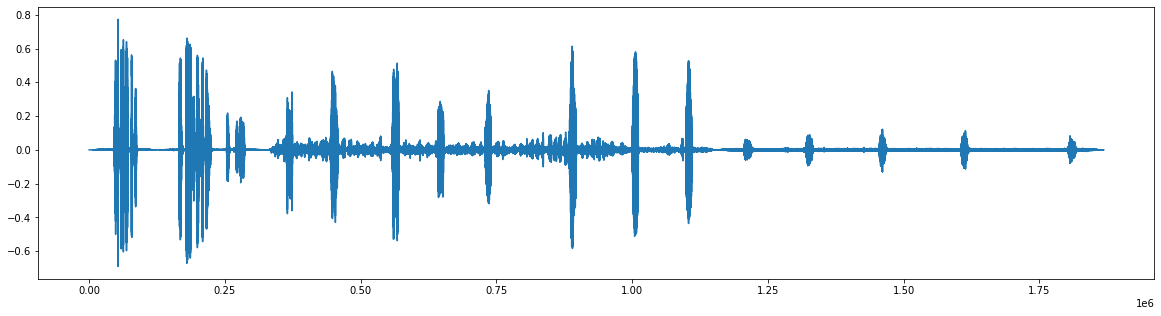

In [10]:
# Cargamos el primer audio de la lista
audio, sr = librosa.load('/content/IEBS/Data/'+filenames[0])
plt.figure(figsize=(20,5))
plt.plot(audio)
ipd.Audio(audio, rate=sr)

### Preprocesamiento


Se define una función para la extracción de N muestras de 5 segundos de duración para cada archivo de audio convertida cada una en espectrograma

In [11]:
class coefs:
       
    # Global vars
    sr = 44100               # librosa sample rate input
    sec = 5                  # seconds   
    sshape = (128, 128)       # height x width
    fmin = 500               # spectrum min frequency
    fmax = 12500             # spectrum max frequency

In [15]:
def extraer_muestras(filename, n_muestras):
    """
    ARGS
      filename: archivo de audio a procesar
      n_muestras: cantidad de muestras a obtener
    """
    carpeta = filename[:-4]
    path_save = '/content/IEBS/Audioimagen/' + carpeta
    os.makedirs(path_save, exist_ok=True)
        
    audio, _ = librosa.load('/content/IEBS/Data/'+filename)
    

    for n in range(n_muestras):
        start = np.random.randint(1, len(audio)-(coefs.sec * coefs.sr))
        chunk = audio[start:start + coefs.sec * coefs.sr]

        # Espectrograma para cada segmento de audio -------------------------
        hop_length = int(coefs.sec * coefs.sr / (coefs.sshape[1] - 1))
        mel_spec = librosa.feature.melspectrogram(y = chunk, 
                                                  sr = coefs.sr, 
                                                  n_fft = 1024, 
                                                  hop_length = hop_length, 
                                                  n_mels = coefs.sshape[0], 
                                                  fmin = coefs.fmin, 
                                                  fmax = coefs.fmax)
        
        mel_spec = librosa.power_to_db(mel_spec**2, ref=np.max) 

        # Normalize
        mel_spec -= mel_spec.min()
        mel_spec /= mel_spec.max()
        
        # Grabar imagen ------------------------------------------------------
        im = Image.fromarray(mel_spec * 255.0).convert("L")
        im.save(path_save+'/'+f'{carpeta}_{n}.png')

    print(f" {carpeta} - {n_muestras} Imágenes generadas")
    
    return 

In [14]:
for i in range(len(filenames)):
  extraer_muestras(filenames[i], 1000)

 BENTEVEO_COMÚN - Imágenes generadas
 CABECITANEGRA_COMÚN - Imágenes generadas
 CALANDRIA_GRANDE - Imágenes generadas
 CARDENAL_AMARILLO - Imágenes generadas
 CARDENAL_COMUN - Imágenes generadas
 COTORRA - Imágenes generadas
 GOLONDRINA_DOMÉSTICA - Imágenes generadas
 GORRIÓN - Imágenes generadas
 HORNERO - Imágenes generadas
 JILGUERO_DORADO - Imágenes generadas
 RUIDO - Imágenes generadas
 ZORZAL_COLORADO - Imágenes generadas


## Modelo Convolucional

In [17]:
import wave
import pylab
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dropout
from keras import layers
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

### Preparar datos de entrenamiento

In [18]:
batch_size = 16
img_height = 128
img_width = 128

DATASET_PATH='/content/IEBS/Audioimagen/'

In [19]:
train_ds = keras.utils.image_dataset_from_directory(
                directory=DATASET_PATH,
                label_mode='categorical',
                validation_split=0.2,
                subset="training",
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 12000 files belonging to 12 classes.
Using 9600 files for training.


In [20]:
val_ds = keras.utils.image_dataset_from_directory(
                directory=DATASET_PATH,
                label_mode='categorical',
                validation_split=0.2,
                subset="validation",
                seed=123,
                image_size=(img_height, img_width),
                batch_size=batch_size)

Found 12000 files belonging to 12 classes.
Using 2400 files for validation.


### Obtener nombre de las clases

In [21]:
class_names = train_ds.class_names
print(class_names)

['BENTEVEO_COMÚN', 'CABECITANEGRA_COMÚN', 'CALANDRIA_GRANDE', 'CARDENAL_AMARILLO', 'CARDENAL_COMUN', 'COTORRA', 'GOLONDRINA_DOMÉSTICA', 'GORRIÓN', 'HORNERO', 'JILGUERO_DORADO', 'RUIDO', 'ZORZAL_COLORADO']


### Visualizar un ejemplo

tf.Tensor([0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(12,), dtype=float32)


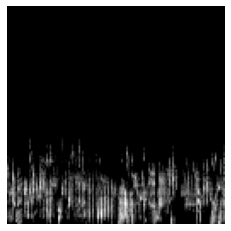

In [22]:
for images, labels in train_ds.take(1):    # cada take contiene la cantidad de imagenes definida en el batch_size
  plt.axis('off')
  plt.imshow(images[0].numpy().astype("uint8")) # visualizamos la primer imagen del batch_size
  print(labels[0])

### Modelo CNN + FC
Se modela la red con 4 capas convolucionales y 2 capas densas

In [23]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5), 

  layers.Dense(256, activation='relu'),
  layers.Dropout(0.5), 

  layers.Dense(num_classes, activation='softmax')
])

In [25]:
model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.01),
              optimizer = keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0

### Entrenamiento

In [27]:
# Definimos una callback para aplicar early stop
callback = [ keras.callbacks.EarlyStopping(patience=2) ]

In [28]:
epochs=10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callback)

Epoch 1/10
600/600 [==============================] - 249s 412ms/step - loss: 0.6018 - accuracy: 0.8265 - val_loss: 0.1063 - val_accuracy: 0.9992
Epoch 2/10
600/600 [==============================] - 246s 410ms/step - loss: 0.1397 - accuracy: 0.9954 - val_loss: 0.0986 - val_accuracy: 1.0000
Epoch 3/10
600/600 [==============================] - 245s 408ms/step - loss: 0.1196 - accuracy: 0.9993 - val_loss: 0.0888 - val_accuracy: 1.0000
Epoch 4/10
600/600 [==============================] - 250s 417ms/step - loss: 0.1105 - accuracy: 0.9993 - val_loss: 0.0888 - val_accuracy: 1.0000
Epoch 5/10
600/600 [==============================] - 243s 404ms/step - loss: 0.1088 - accuracy: 0.9994 - val_loss: 0.0832 - val_accuracy: 1.0000
Epoch 6/10
600/600 [==============================] - 247s 412ms/step - loss: 0.1026 - accuracy: 0.9998 - val_loss: 0.0789 - val_accuracy: 1.0000
Epoch 7/10
600/600 [==============================] - 250s 417ms/step - loss: 0.0991 - accuracy: 0.9999 - val_loss: 0.0808 -

In [29]:
model.save('/content/IEBS/Modelos/modelo.h5')

### Visualización de rendimiento

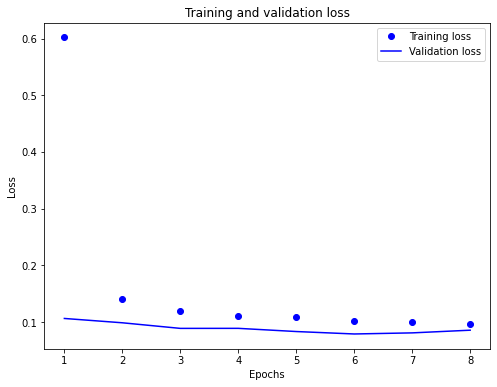

In [30]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

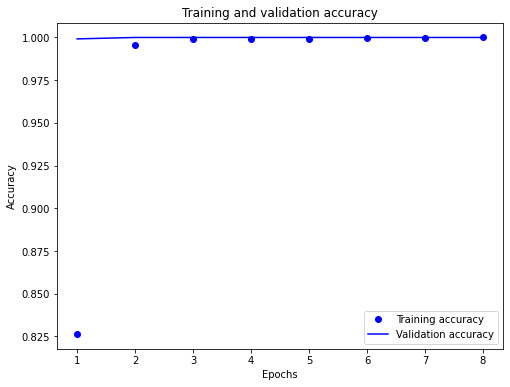

In [31]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values)+1)

plt.figure(figsize=(8,6))
plt.plot(epochs, acc_values, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# Resumen de los valores de loss y accuracy
final_loss, final_acc = model.evaluate(val_ds, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.085569, final accuracy: 1.000000
